In [76]:
import pickle
with open('../bin/storysniffer/model_file.pkl', 'rb') as f:
    model = pickle.load(f)
bounding_box_dfs[0]['is_article'] = bounding_box_dfs[0]['site_url'].pipe(model.predict)

In [30]:
import re
from importlib import reload
import glob
import sys
import os
sys.path.insert(0, '../scripts/')
import get_bounding_boxes_from_html as bb
import seaborn as sns
here = os.getcwd()
import pandas as pd 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt 

In [10]:
bounding_box_dfs = []
for f in tqdm(glob.glob('cache/two-month-nyt-bounding-box-csvs/*')):
    df = pd.read_csv(f, index_col=0) 
    bounding_box_dfs.append(df)

  0%|          | 0/2169 [00:00<?, ?it/s]

In [105]:
bounding_box_dfs = list(map(bb.restrict_to_wayback_urls_and_process, bounding_box_dfs))
bounding_box_dfs = sorted(bounding_box_dfs, key=lambda df: df.iloc[0]['key'])

(1242.0, 12538.3828125, 1242.0, 12610)

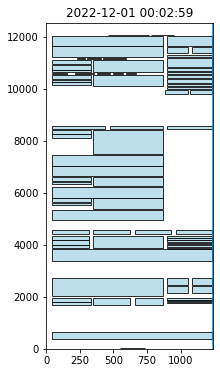

In [106]:
bb.plot_bounding_box_df(
    bounding_box_dfs[0],
    clip_right=True,
    figsize=(3,6)
)

# Using Spacings to Group Article Blocks

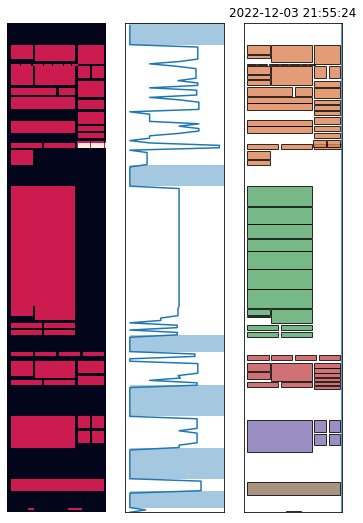

In [315]:
bb_df = bounding_box_dfs[90]

_, axarr = plt.subplots(1, 3, figsize=(6, 9))

# plot grid
grid = bb.get_coarsified_layout_grid(bb_df, clip_x=True)
sns.heatmap(grid, ax=axarr[0], cbar=False)

# plot zero average
m = grid.mean(axis=1)[::-1].reset_index(drop=True)
zero_ranges = get_zero_ranges(m)
axarr[1].plot(m.values, m.index)
ymax, ymin = axarr[0].get_ylim()
xmin, xmax = axarr[1].get_xlim()
## plot shaded rectangles
for s_idx, e_idx in zero_ranges:
    s, e = grid.index[s_idx], grid.index[e_idx-1]
    s, e = s_idx, e_idx
    axarr[1].add_patch(Rectangle((0, s), height=(e-s), width=xmax, alpha=.4)) 
axarr[1].set_xlim((xmin, xmax))
axarr[1].set_ylim((ymin, ymax))

# bin each article and plot it color-shaded
m = grid.mean(axis=1)
g_idx = grid.index
r_idxs = get_zero_ranges(m)
segments = list(map(lambda x: convert_to_grid_idx(x, g_idx), r_idxs))
bands = list(map(lambda x: sum(x) / 2, segments))
bb_df['bands'] = np.digitize(bb_df['y'], bands)
palette = sns.color_palette('deep')
colors = bb_df['bands'].apply(lambda x: palette[x])

bb.plot_bounding_box_df(
    bb_df,
    clip_right=True,
    colors=colors,
    figsize=(3,6),
    ax=axarr[2]
)

for ax in axarr:
    ax.set_xticks([]), ax.set_yticks([])

# Adjust Bands

In [441]:
band_start_stops = []
for bb_df in tqdm(bounding_box_dfs[:500]):
    bb_df['bands'] = bb_df.pipe(get_bands_for_each_article)
    one_df_start_stop = get_min_max_height_for_each_band(bb_df)
    band_start_stops.append(one_df_start_stop)

  0%|          | 0/500 [00:00<?, ?it/s]

In [442]:
# number of bands
num_banding_patterns = list(set(map(lambda x: x.shape[0], band_start_stops)))
pd.Series(map(lambda x: x.shape[0], band_start_stops)).value_counts()

5    252
6    193
7     51
8      4
dtype: int64

In [513]:
# def resize_homepage()

In [444]:
mean_start_stops = {
    i: get_mean_start_stops_shifted(i, band_start_stops) 
    for i in num_banding_patterns
}

In [ ]:
squeezed_bb_dfs = []
for bb_df in tqdm(bounding_box_dfs):
    if 'bands' not in bb_df:
        bb_df['bands'] = get_bands_for_each_article(bb_df)
    t = resize_bb_df_by_bands(bb_df, mean_start_stops)
    squeezed_bb_dfs.append(t)

In [486]:
homepage_grids = []
for bb_df in tqdm(squeezed_bb_dfs):
    g = bb.get_coarsified_layout_grid(
        bb_df, clip_x=True, use_perc=True, max_count=1
    )
    homepage_grids.append(g)

  0%|          | 0/520 [00:00<?, ?it/s]

In [577]:
mean_placement_overall = sum(homepage_grids) / len(homepage_grids)

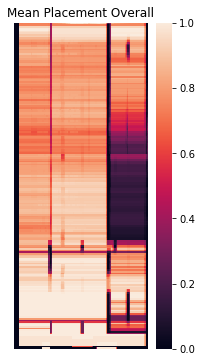

In [603]:
_, ax = plt.subplots(1, 1, figsize=(3, 6))
ax = sns.heatmap(mean_placement_overall)#, cbar=None)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Mean Placement Overall');

In [524]:
add_del_bb_dfs = {}
all_merged_bb_dfs = []
for idx in tqdm(range(len(squeezed_bb_dfs) - 1)):
    merged_bb_df, del_bb_df, add_bb_df = bb.merge_and_dedupe_bbs(
        squeezed_bb_dfs[idx], squeezed_bb_dfs[idx + 1]
    )
    
    add_del_bb_dfs[idx + 1] = add_bb_df
    if idx in add_del_bb_dfs:
        add_bb_df = add_del_bb_dfs[idx]
        add_bb_df = (add_bb_df
         .rename(columns={'action': 'action_to_new'})
         .assign(action_to_old=del_bb_df['action'])
        )
    add_del_bb_dfs[idx] = add_bb_df
    all_merged_bb_dfs.append(merged_bb_df)

  0%|          | 0/519 [00:00<?, ?it/s]

In [533]:
add_del_bb_dfs = list(add_del_bb_dfs.values())

In [552]:
added_grids = []
for bb_df in tqdm(add_del_bb_dfs):
    page_height = (
        bb_df.pipe(lambda df: df['y'] + df['height']).max()
    )
    page_width = bb.get_clip_size_grid(bb_df)
    g = bb.get_coarsified_layout_grid(
        bb_df.loc[lambda df: df['action_to_new'] == 'added'],
        max_height=page_height,
        max_width=page_width,
        use_perc=True,
    )
    added_grids.append(g)

  0%|          | 0/518 [00:00<?, ?it/s]

In [576]:
deleted_grids = []
for bb_df in tqdm(add_del_bb_dfs):
    page_height = (
        bb_df.pipe(lambda df: df['y'] + df['height']).max()
    )
    page_width = bb.get_clip_size_grid(bb_df)
    g = bb.get_coarsified_layout_grid(
        bb_df.loc[lambda df: df['action_to_old'] == 'deleted'],
        max_height=page_height,
        max_width=page_width,
        use_perc=True,
    )
    deleted_grids.append(g)

  0%|          | 0/518 [00:00<?, ?it/s]

In [564]:
mean_added = sum(added_grids) / len(added_grids)

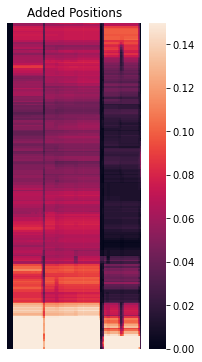

In [602]:
_, ax = plt.subplots(1, 1, figsize=(3,6))
sns.heatmap(mean_added, vmax=.15)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Added Positions') ;

In [ ]:
mean_added / mean_placement_overall

In [586]:
mean_deleted = sum(deleted_grids) / len(deleted_grids)

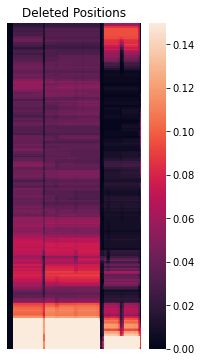

In [600]:
_, ax = plt.subplots(1, 1, figsize=(3,6))
sns.heatmap(mean_deleted, ax=ax, vmax=.15)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Deleted Positions') ;

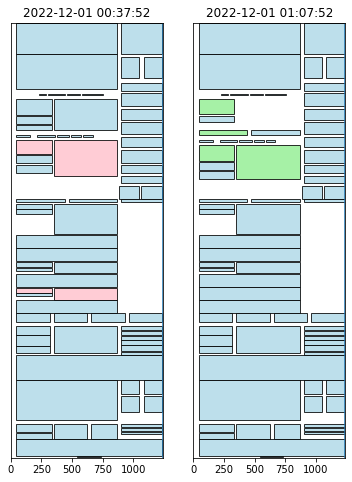

In [734]:
idx = 1
merged_bb_df, bb_1, bb_2 = bb.merge_and_dedupe_bbs(
    squeezed_bb_dfs[idx], squeezed_bb_dfs[idx + 1]
)

bb.plot_merged_df(
    merged_bb_df, bb_1=bb_1, bb_2=bb_2, figsize=(6, 8),
    plot_arrows=False
    
)

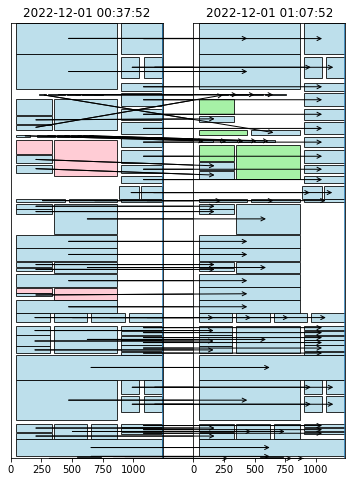

In [682]:
idx = 1
merged_bb_df, bb_1, bb_2 = bb.merge_and_dedupe_bbs(
    squeezed_bb_dfs[idx], squeezed_bb_dfs[idx + 1]
)

bb.plot_merged_df(
    merged_bb_df, bb_1=bb_1, bb_2=bb_2, figsize=(6, 8)
)

In [721]:
def m_to_bb(m_bb):
    new_version_cols = [
        'href_y', 'x_y', 'y_y', 'width_y', 'height_y',
    ]
    for c in ['page_width', 'page_height']:
        if c in m_bb:
            new_version_cols.append(c)
    bb = m_bb[new_version_cols]
    return bb.rename(columns=lambda x: x.replace('_y', ''))


all_upwards_move_articles = []
all_downwards_move_articles = []
move_threshold = .1
for idx in tqdm(range(len(all_merged_bb_dfs))):
    m_bb_df = all_merged_bb_dfs[idx]
    page_height = (m_bb_df['y_y'] + m_bb_df['height_y']).max()
    page_width = bb.get_clip_size_grid(m_to_bb(m_bb_df))
    
    upwards_moved_articles = (m_bb_df
     .assign(rise=lambda df: -(df['y_y'] - df['y_x']))
     .loc[lambda df: (df['rise'] / page_height) > move_threshold]
     .assign(page_width=page_width)
     .assign(page_height=page_height)
    )
    
    downwards_moved_articles = (m_bb_df
     .assign(rise=lambda df: -(df['y_y'] - df['y_x']))
     .loc[lambda df: (df['rise'] / page_height) < - move_threshold]
     .assign(page_width=page_width)
     .assign(page_height=page_height)
    )
    if len(upwards_moved_articles ) > 0:
        all_upwards_move_articles.append(upwards_moved_articles)
    if len(downwards_moved_articles ) > 0:
        all_downwards_move_articles.append(downwards_moved_articles)


  0%|          | 0/519 [00:00<?, ?it/s]

In [722]:
upwards_grids = []
for m in tqdm(all_upwards_move_articles):
    g = bb.get_coarsified_layout_grid(
        m_to_bb(m),
        max_height=m.iloc[0]['page_height'], 
        max_width=m.iloc[0]['page_width'],
        use_perc=True
    )
    upwards_grids.append(g)

downwards_grids = []
for m in tqdm(all_downwards_move_articles):
    g = bb.get_coarsified_layout_grid(
        m_to_bb(m),
        max_height=m.iloc[0]['page_height'], 
        max_width=m.iloc[0]['page_width'],
        use_perc=True
    )
    downwards_grids.append(g)

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

In [723]:
mean_up_grid_10 = sum(upwards_grids) / len(upwards_grids)

In [724]:
mean_down_grid_10 = sum(downwards_grids) / len(downwards_grids)

In [ ]:
mean_up_grid_05 = mean_up_grid
mean_down_grid_05 = mean_down_grid

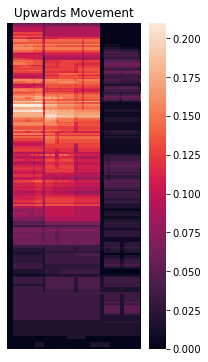

In [731]:
_, ax = plt.subplots(1, 1, figsize=(3,6))
sns.heatmap(mean_up_grid_10, ax=ax)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Upwards Movement') ;

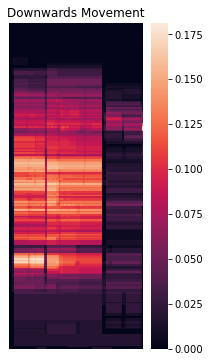

In [732]:
_, ax = plt.subplots(1, 1, figsize=(3,6))
sns.heatmap(mean_down_grid_10, ax=ax)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title('Downwards Movement') ;

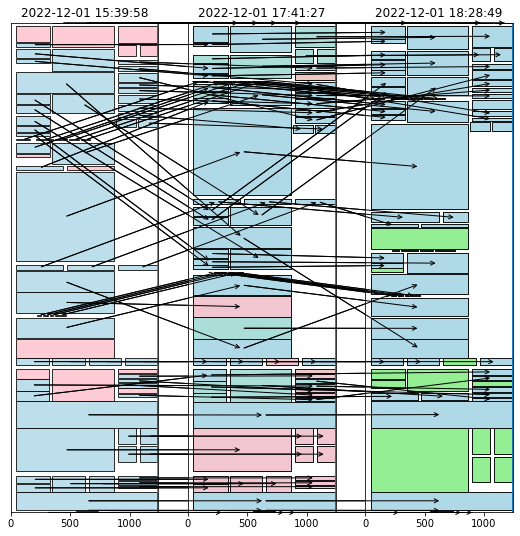

In [737]:
idx = 23
merged_bb_df, bb_1, bb_2 = bb.merge_and_dedupe_bbs(
    squeezed_bb_dfs[idx], squeezed_bb_dfs[idx + 1]
)

_, axarr = plt.subplots(1, 3, figsize=(9, 9))

bb.plot_merged_df(merged_bb_df, bb_1=bb_1, bb_2=bb_2, axarr=axarr)


merged_bb_df_2, bb_2, bb_3 = bb.merge_and_dedupe_bbs(
    squeezed_bb_dfs[idx + 1], squeezed_bb_dfs[idx + 2]
)
bb.plot_bounding_box_df(bb_3, clip_right=True, ax=axarr[2])
bb.plot_merged_df(
    merged_bb_df_2, bb_1=bb_2, bb_2=bb_3, axarr=[axarr[1], axarr[2]],
    plot_individual=True ## fix
)